In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.5 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting un

In [3]:
import pandas as pd
import numpy as np
import math
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

yf.pdr_override()

In [4]:
comp_list = ['GS','WFC','GOOGL','META','ROKU']

In [5]:
end_date = datetime.now()
start_date = datetime(end_date.year - 10 , end_date.month, end_date.day)
stock_data = []
for company in comp_list:
    comp_stock = yf.download(company,start_date,end_date)
    stock_data.append(comp_stock)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [73]:
def run_model_company(company_index):
  company_name = comp_list[company_index]
  print(company_name)
  company = stock_data[company_index]
  plt.figure(figsize=(16,8))
  plt.plot(company['Close'])
  plt.show()
  company_close_df = company.filter(['Close'])
  company_data = company_close_df.values
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_company = scaler.fit_transform(company_data)
  training_data_len = int(np.ceil( len(company_data) * .9 ))
  train_data = scaled_company[0:training_data_len, : ]
  # print(train_data.shape)
  num_days = 30
  x_train = []
  y_train = []

  for i in range(0, len(train_data) - num_days):
      x_train.append(train_data[i:i + num_days, 0])
      y_train.append(train_data[i+num_days,0])

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  # print(x_train.shape,y_train.shape)
  x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
  # print(x_train.shape)
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
  model.add(LSTM(128,return_sequences = False))
  model.add(Dense(32))
  model.add(Dense(1))
  model.compile(optimizer= 'adam', loss ='mean_squared_error')
  model.fit(x_train,y_train,batch_size = 1,epochs = 1)
  test_data = scaled_company[training_data_len - num_days: , :]
  # print(len(test_data))
  x_test, y_test = [], company_data[training_data_len:,:]
  # print(len(x_test),y_test.shape)
  for i in range(0, len(test_data) -num_days):
    x_test.append(test_data[i:i+num_days,0])
  x_test = np.array(x_test)
  # print(x_test.shape)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
  pred = model.predict(x_test)
  pred_unscaled = scaler.inverse_transform(pred)
  rmse_error = np.sqrt(np.mean(((pred_unscaled - y_test) ** 2)))
  mean_absolute_error = np.mean(np.absolute(pred_unscaled - y_test))
  print(company_name,"rmse_error:", rmse_error)
  print(company_name,"mean absolute error:", mean_absolute_error)
  index_array = [i for i in range(pred_unscaled.shape[0])]
  plt.plot(index_array,pred_unscaled , label = 'predictions')
  plt.plot(index_array, y_test, label = 'real values')
  plt.title(company_name)
  plt.legend()
  plt.show()


GS


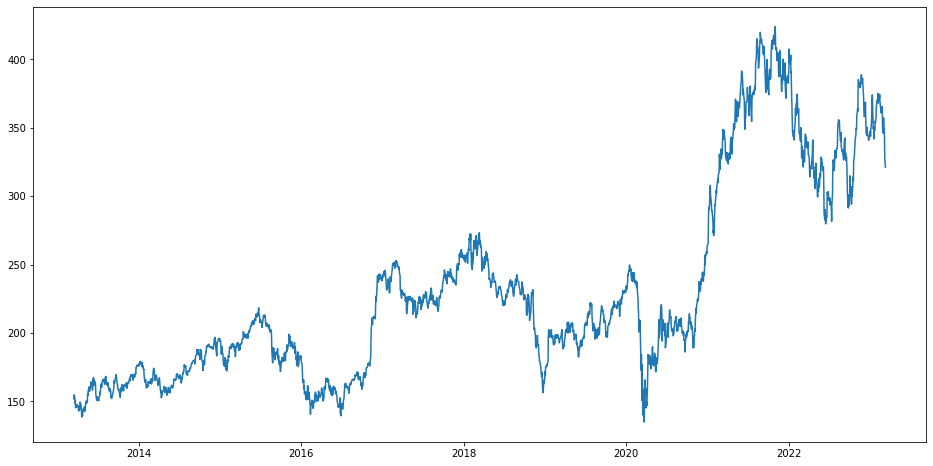

8/8 [==============================] - 1s 36ms/step
GS rmse_error: 9.901540149643976
GS mean absolute error: 7.839751224593813


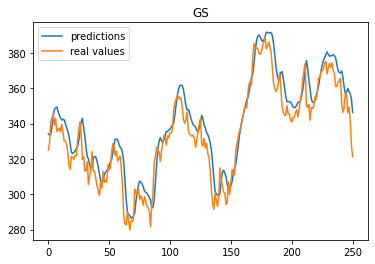

WFC


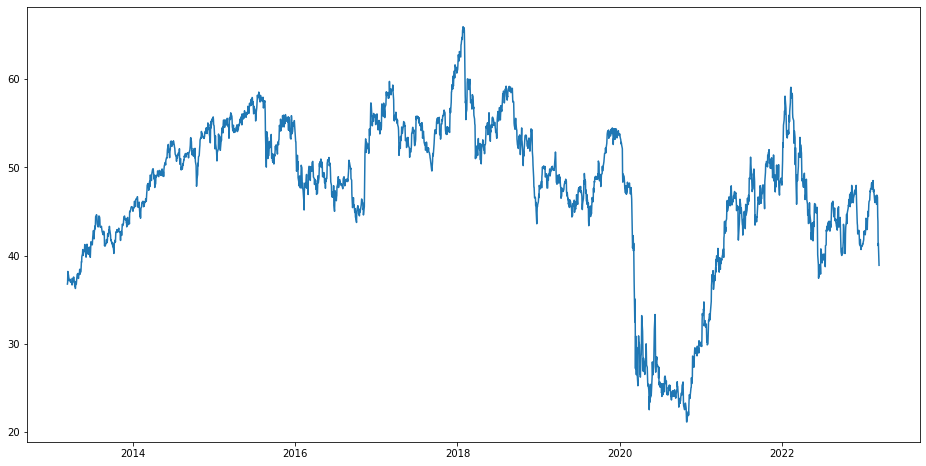

8/8 [==============================] - 1s 40ms/step
WFC rmse_error: 1.118736376761082
WFC mean absolute error: 0.8634557382044089


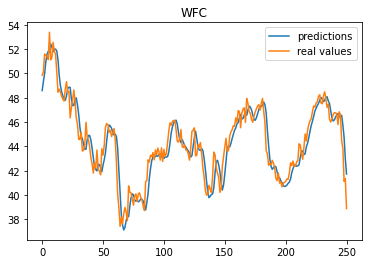

GOOGL


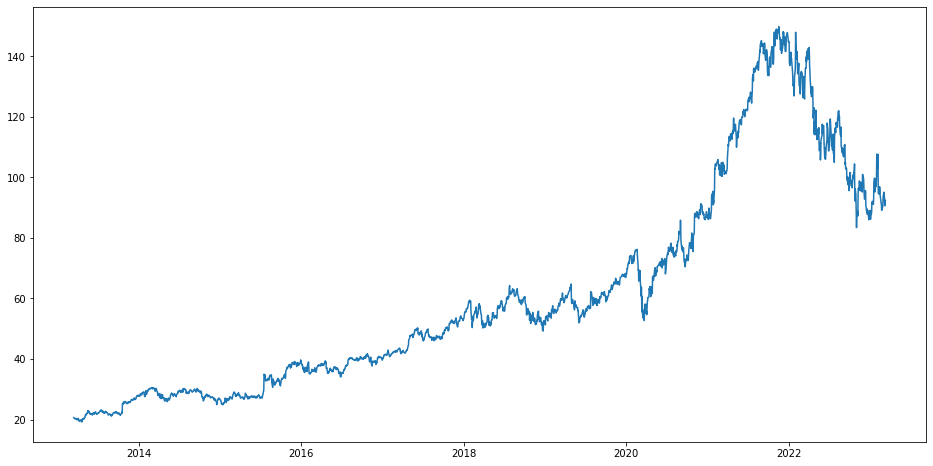

8/8 [==============================] - 1s 38ms/step
GOOGL rmse_error: 3.76078003256391
GOOGL mean absolute error: 3.1375015076413098


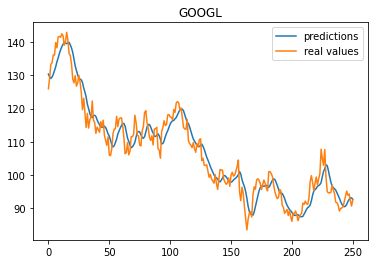

META


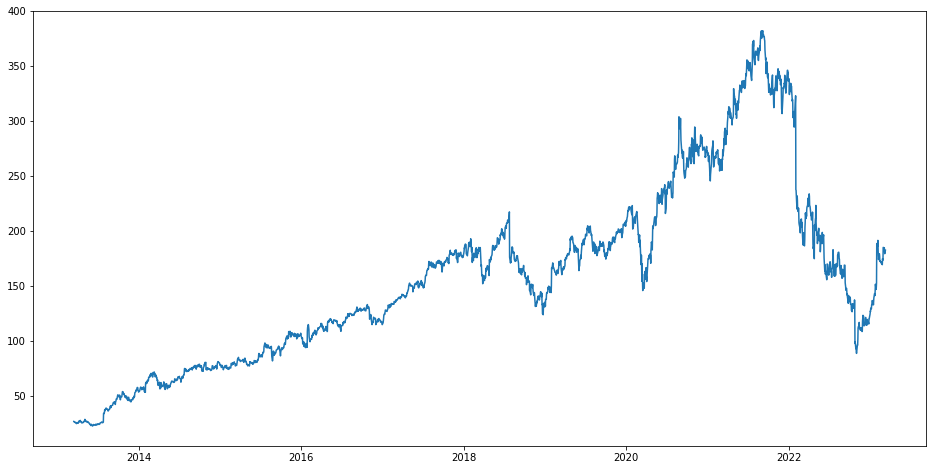

8/8 [==============================] - 1s 38ms/step
META rmse_error: 12.406087325676825
META mean absolute error: 9.574828767206565


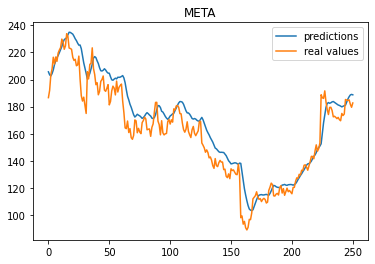

ROKU


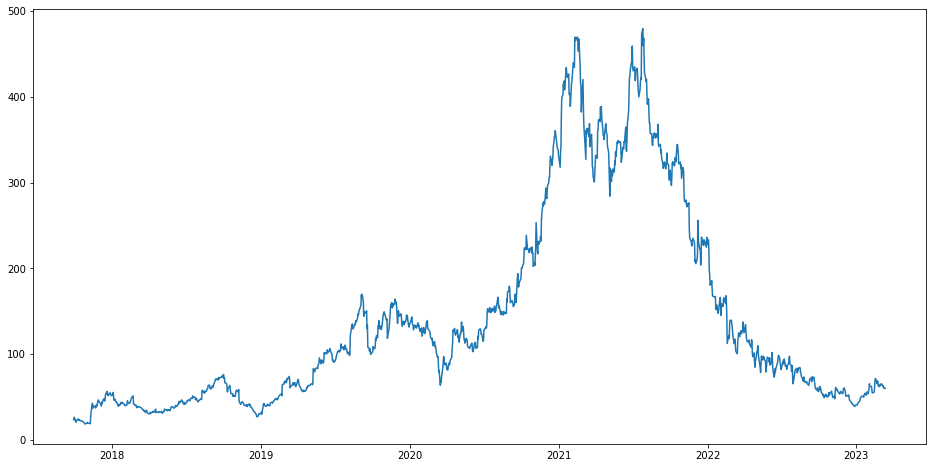

5/5 [==============================] - 1s 41ms/step
ROKU rmse_error: 7.822217043889508
ROKU mean absolute error: 6.962498797117359


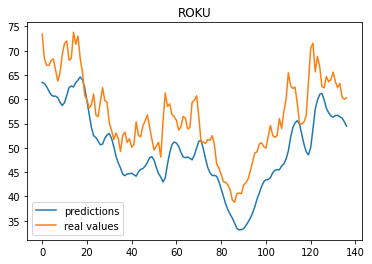

In [74]:
for i in range(len(comp_list)):
  run_model_company(i)

## google

In [6]:
google = stock_data[2]
google.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-13,20.718218,20.788038,20.578327,20.653402,20.653402,65586348
2013-03-14,20.695444,20.695444,20.455206,20.559059,20.559059,65981952
2013-03-15,20.482983,20.528028,20.353853,20.377878,20.377878,123864012
2013-03-18,20.145145,20.339338,20.056807,20.214966,20.214966,73458468
2013-03-19,20.301300,20.501753,20.181431,20.303303,20.303303,83844072


In [7]:
google.shape

(2518, 6)

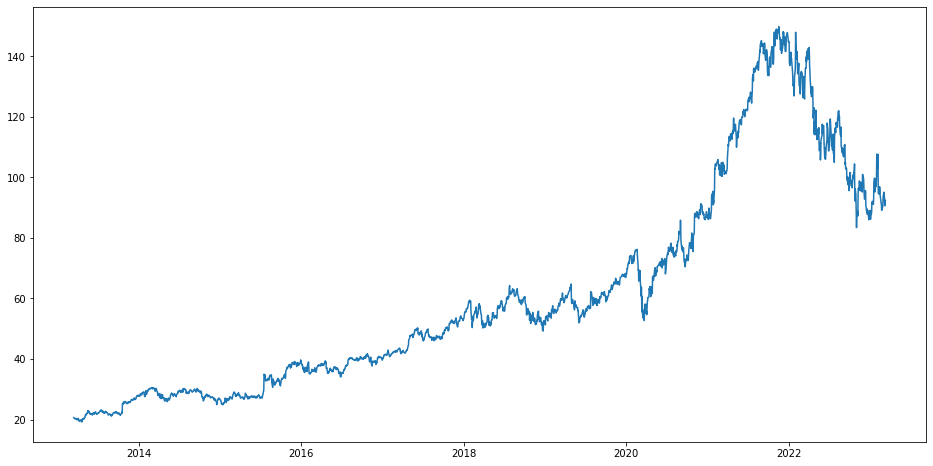

In [8]:
plt.figure(figsize=(16,8))
plt.plot(google['Close'])
plt.show()

In [42]:
google_close_df = google.filter(['Close'])
google_data = google_close_df.values
google
print(google_data.shape)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_google = scaler.fit_transform(google_data)


(2518, 1)


In [21]:
training_data_len = int(np.ceil( len(google_data) * .9 ))

In [55]:
train_data = scaled_google[0:training_data_len, : ]
print(train_data.shape)
num_days = 30
x_train = []
y_train = []

for i in range(0, len(train_data) - num_days):
    x_train.append(train_data[i:i + num_days, 0])
    y_train.append(train_data[i+num_days,0])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape,y_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(2267, 1)
(2237, 30) (2237,)
(2237, 30, 1)


In [56]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(128,return_sequences = False))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer= 'adam', loss ='mean_squared_error')
model.fit(x_train,y_train,batch_size = 1,epochs = 1)

2237/2237 [==============================] - 70s 30ms/step - loss: 0.0017


In [57]:
test_data = scaled_google[training_data_len - num_days: , :]
print(len(test_data))
x_test, y_test = [], google_data[training_data_len:,:]
print(len(x_test),y_test.shape)
for i in range(0, len(test_data) -num_days):
  x_test.append(test_data[i:i+num_days,0])
x_test = np.array(x_test)
print(x_test.shape)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
pred = model.predict(x_test)
pred_unscaled = scaler.inverse_transform(pred)
rmse_error = np.sqrt(np.mean(((pred_unscaled - y_test) ** 2)))
mean_absolute_error = np.mean(np.absolute(pred_unscaled - y_test))
print("rmse_error:", rmse_error)
print("mean absolute error:", mean_absolute_error)

281
0 (251, 1)
(251, 30)
8/8 [==============================] - 1s 34ms/step
rmse_error: 4.036437600729117
mean absolute error: 3.260526467129529


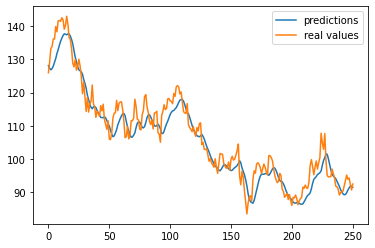

In [58]:
# "index_array = [i for i in range(pred_unscaled.shape[0])]
plt.plot(index_array,pred_unscaled , label = 'predictions')
plt.plot(index_array, y_test, label = 'real values')
plt.legend()
plt.show()